# Problema de classificação binária - atributo alvo (y) é discreto y = {0,1}

Ex. Dado um conjunto de atributos X (localização, ganhos, funcionarios, ...) e um valor discreto (y) indicando que a empresa foi classificada como empresa com risco de fraude (y = 1) ou empresa sem risco (y = 0) treinar uma rede neural capaz de predizer o valor de y para exemplos de pacientes (X) que não foram apresentados à rede durante o treinamento.

## Estrutura da rede
**Input -> Hidden Layers -> Output**

**Input:** número de valores em X;

**Hidden Layers:** estrutura definida e testada pelo desenvolvedor (número de camadas, número de neurônios em cada camada, função de ativação de cada camada, etc);

**Output:** 1 neurônio com função de ativação sigmoid (f(x) = sigmoid(x)) uma vez que queremos que esta rede apresente como saída final um valor discreto. A saída da função sigmoide será um valor contínuo na faixa [0,1] e para os problemas binários, usa um ponto de corte (normalmente em 0,5) para se obter as saídas 0 ou 1 no final da rede.

**Outros elementos importantes:**

**Loss function:** como os valores verdadeiros de y e os preditos são valores discretos, para calcular quanto a rede está errando para cada exemplo em um problema de classificação binária, a função de perda recomendade é a binary_crossentropy. Para saber mais: https://keras.io/api/losses/probabilistic_losses/#binary_crossentropy-function

**Optimizer:** define como será feito o ajuste dos pesos. Regra geral, Adam é a melhor escolha quando você não sabe qual utilizar, mas em busca de melhores resultado é importante testar o SGD e o RMSProp. Para saber mais: https://keras.io/api/optimizers/


In [1]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras import optimizers
from keras import layers
from keras import regularizers

import numpy as np
from numpy import loadtxt

from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error


import pandas as pd
# apresenta a versão do keras - lembre de procurar a documentação para esta versão
keras.__version__

'2.12.0'

In [2]:
# Exemplo de rede MLP para um problema de classificação binária
# dataset: audit_risk_filtered.csv

# montar o drive
from google.colab import drive
drive.mount('/content/drive')

# os arquivos usados nos exemplos da disciplina podem ser obtidos aqui: https://drive.google.com/drive/folders/1X-jGvPAb-i69_Rahdh9pCO-tc5-U-QV5?usp=share_link
# acesso a um arquivo (csv) o raiz do google drive montado fica dentro das pastas drive/MyDrive/
dataset = loadtxt("drive/MyDrive/datasetsBLU8002/audit_risk_filtered.csv", delimiter=',')

# apresenta as primeiras linhas do dataset
dataset


Mounted at /content/drive


array([[ 3.89  , 23.    ,  4.18  , ...,  0.5   ,  1.7148,  1.    ],
       [ 3.89  ,  6.    ,  0.    , ...,  0.5   ,  0.5108,  0.    ],
       [ 3.89  ,  6.    ,  0.51  , ...,  0.5   ,  0.3096,  0.    ],
       ...,
       [55.57  , 14.    ,  0.24  , ...,  0.5   ,  0.2912,  0.    ],
       [55.57  , 18.    ,  0.2   , ...,  0.5   ,  0.288 ,  0.    ],
       [55.57  , 15.    ,  0.    , ...,  0.5   ,  0.2928,  0.    ]])

In [3]:
# verificar o formato do dataset
print(dataset.shape)


(776, 27)


In [4]:
# split into input (X) and output (y) variables
# neste problema o atributo alvo (y) é o index 8, 
# os atributos descritivos são index 0-7
X = dataset[:, 0:25]
y = dataset[:, 26]

print(X)
print(y)

[[ 3.89  23.     4.18  ...  8.574  0.4    0.5  ]
 [ 3.89   6.     0.    ...  2.554  0.4    0.5  ]
 [ 3.89   6.     0.51  ...  1.548  0.4    0.5  ]
 ...
 [55.57  14.     0.24  ...  1.456  0.4    0.5  ]
 [55.57  18.     0.2   ...  1.44   0.4    0.5  ]
 [55.57  15.     0.    ...  1.464  0.4    0.5  ]]
[1. 0. 0. 1. 0. 0. 1. 1. 1. 0. 1. 1. 1. 0. 0. 1. 1. 1. 0. 1. 1. 0. 1. 0.
 1. 1. 0. 1. 0. 0. 1. 1. 0. 0. 0. 0. 1. 0. 1. 1. 1. 0. 0. 0. 0. 0. 1. 0.
 1. 1. 1. 1. 0. 0. 1. 0. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 0. 1. 0. 0. 1. 1.
 1. 1. 0. 1. 1. 1. 1. 0. 1. 1. 0. 0. 0. 1. 0. 1. 1. 1. 1. 0. 0. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 0. 0. 0. 0. 1. 0. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 0.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 

In [5]:
# normaliza os dados de X 
# existem várias outras técnicas para normalização, está é a mais simples e direta
trans = MinMaxScaler()
X = trans.fit_transform(X)

print(X)

# neste problema não há necessidade de normalizar o y pois y = {0,1}

[[3.51724138e-02 4.23076923e-01 4.91764706e-02 ... 8.96904716e-03
  0.00000000e+00 0.00000000e+00]
 [3.51724138e-02 9.61538462e-02 0.00000000e+00 ... 1.44274887e-03
  0.00000000e+00 0.00000000e+00]
 [3.51724138e-02 9.61538462e-02 6.00000000e-03 ... 1.85031918e-04
  0.00000000e+00 0.00000000e+00]
 ...
 [9.26206897e-01 2.50000000e-01 2.82352941e-03 ... 7.00120771e-05
  0.00000000e+00 0.00000000e+00]
 [9.26206897e-01 3.26923077e-01 2.35294118e-03 ... 5.00086265e-05
  0.00000000e+00 0.00000000e+00]
 [9.26206897e-01 2.69230769e-01 0.00000000e+00 ... 8.00138024e-05
  0.00000000e+00 0.00000000e+00]]


In [6]:
# divide os datasets em treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.23)

# apresenta 5 instancias
print("\nExemplos de treinamento")
print(np.column_stack((X_train[0:25,:], y_train[0:25])))
print("\nExemplos de teste")
print(np.column_stack((X_train[0:25,:], y_train[0:25])))


Exemplos de treinamento
[[0.00000000e+00 9.61538462e-02 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  1.06834183e-03 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.92307692e-01 1.98823529e-02 5.00000000e-01
  1.32549020e-02 1.66056475e-04 0.00000000e+00 5.53521583e-05
  1.49734812e-03 0.00000000e+00 0.00000000e+00 0.00000000e+00
  1.06834183e-03 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 6.25000000e-02 8.97654845e-04 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [3.40689655e-01 2.11538462e-01 2.23529412e-03 0.00000000e+00
  7.45098039e-04 1.81871377e-04 0.00000000e+00 6.06237925e-05
  3.30992742e-04 0.00000000e+00 0.0000000

In [7]:
# definindo a rede neural

# define the keras model
model = Sequential()

# na primeira camada escondida definimos o número de variáveis de entrada através do parâmetro input_dim
# abaixo definimos 5 camadas escondidas com 12 neurônios cada e uma com 6 neurônios
model.add(Dense(12, input_dim=X.shape[1], activation='relu')) 
model.add(Dense(12, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(6, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(12, activation='relu'))

# abaixo a camada de saída com 1 neurônio e função de ativação f(x) = sigmoid(x)
model.add(Dense(1, activation='sigmoid'))
model.summary()




Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 12)                312       
                                                                 
 dense_1 (Dense)             (None, 12)                156       
                                                                 
 dense_2 (Dense)             (None, 12)                156       
                                                                 
 dense_3 (Dense)             (None, 6)                 78        
                                                                 
 dense_4 (Dense)             (None, 12)                84        
                                                                 
 dense_5 (Dense)             (None, 12)                156       
                                                                 
 dense_6 (Dense)             (None, 1)                 1

In [8]:
# definindo outros componentes da rede e compilando-a
# loss function = binary_cross_entropy, optimizer = Adan e a métrica que a própria rede usará para avaliar seu desempenho que também será a accuracy
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# fit the keras model on the dataset - treinando a rede
history = model.fit(X_train, y_train, epochs=10, batch_size=6, verbose=1, validation_split=0.2)

Epoch 1/10
80/80 [==============================] - 8s 7ms/step - loss: 0.6616 - accuracy: 0.7484 - val_loss: 0.5855 - val_accuracy: 0.9167
Epoch 2/10
80/80 [==============================] - 0s 5ms/step - loss: 0.4026 - accuracy: 0.9203 - val_loss: 0.1879 - val_accuracy: 0.9750
Epoch 3/10
80/80 [==============================] - 0s 5ms/step - loss: 0.1450 - accuracy: 0.9497 - val_loss: 0.0975 - val_accuracy: 0.9583
Epoch 4/10
80/80 [==============================] - 0s 5ms/step - loss: 0.1075 - accuracy: 0.9560 - val_loss: 0.1228 - val_accuracy: 0.9500
Epoch 5/10
80/80 [==============================] - 0s 5ms/step - loss: 0.1010 - accuracy: 0.9581 - val_loss: 0.0994 - val_accuracy: 0.9583
Epoch 6/10
80/80 [==============================] - 0s 5ms/step - loss: 0.0852 - accuracy: 0.9623 - val_loss: 0.1253 - val_accuracy: 0.9500
Epoch 7/10
80/80 [==============================] - 0s 5ms/step - loss: 0.0778 - accuracy: 0.9665 - val_loss: 0.1526 - val_accuracy: 0.9583
Epoch 8/10
80/80 [==

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


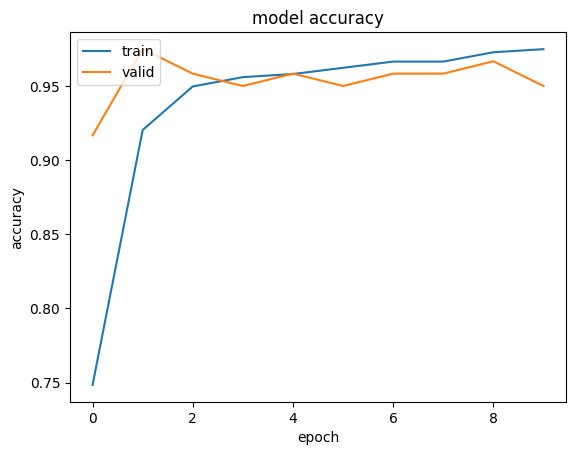

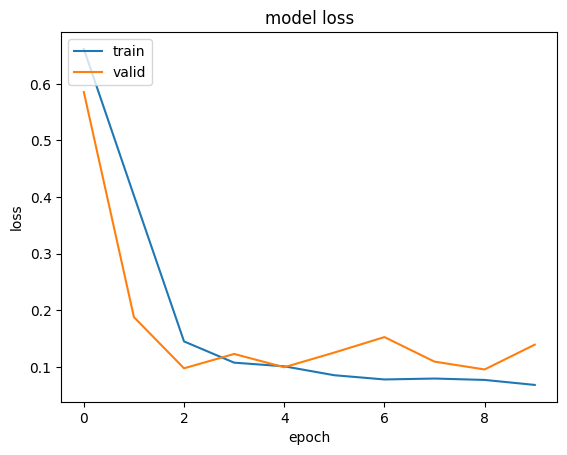

In [9]:
# plotting history data

import matplotlib.pyplot as plt

print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()


In [10]:
# verificando o desempenho nos dados separados para teste

# make predictions
predictions = model.predict(X_test) >= 0.5

# show real, predicted
print(np.column_stack((y_test, predictions)))

print('Confusion Matrix')
print(confusion_matrix(y_test, predictions))

print('Accuracy: %f' %(accuracy_score(y_test, predictions)))

print('Weka:')


6/6 [==============================] - 0s 2ms/step
[[1. 1.]
 [0. 0.]
 [1. 1.]
 [1. 1.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [1. 1.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [1. 1.]
 [0. 0.]
 [1. 1.]
 [1. 1.]
 [0. 0.]
 [0. 0.]
 [1. 1.]
 [1. 1.]
 [0. 0.]
 [0. 0.]
 [1. 0.]
 [1. 1.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [1. 1.]
 [1. 1.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [1. 1.]
 [1. 1.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [1. 1.]
 [1. 1.]
 [0. 0.]
 [0. 0.]
 [1. 1.]
 [0. 0.]
 [1. 1.]
 [1. 1.]
 [0. 0.]
 [0. 0.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [0. 0.]
 [1. 1.]
 [0. 0.]
 [0. 0.]
 [1. 1.]
 [0. 0.]
 [1. 1.]
 [1. 1.]
 [0. 0.]
 [0. 0.]
 [1. 1.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 1.]
 [1. 1.]
 [0. 0.]
 [1. 1.]
 [0. 0.]
 [1. 1.]
 [0. 0.]
 [1. 1.]
 [0. 0.]
 [1. 1.]
 [1. 1.]
 [0. 0.]
 [1. 1.]
 [1. 1.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [1. 1.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [1. 1.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [1. 1.]
 [0.

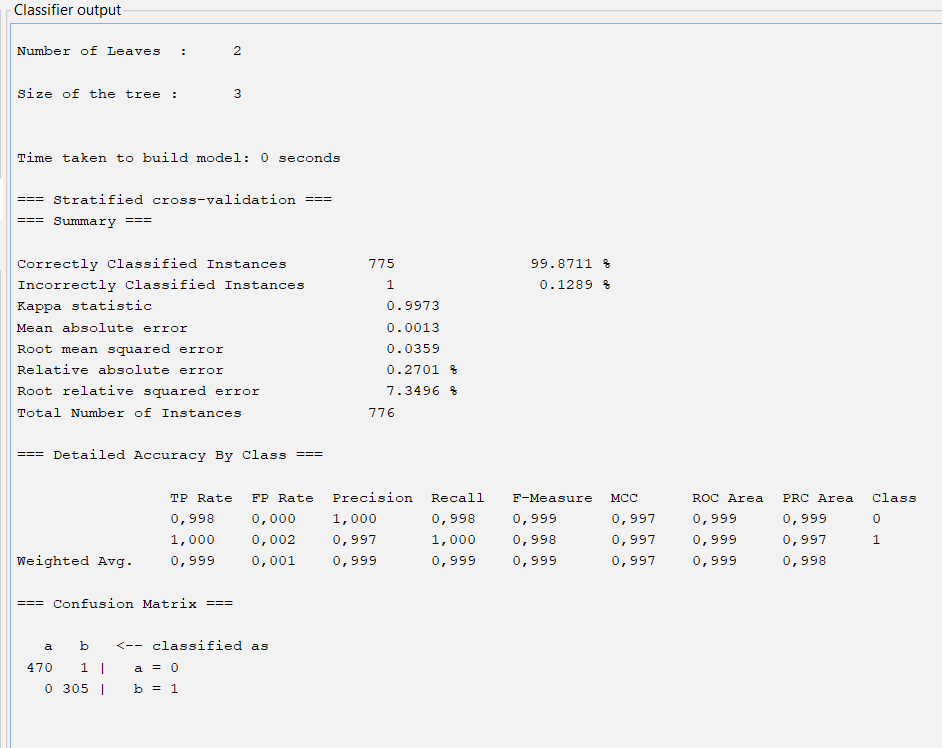